# Final Project Submission

Please fill out:
* Student name: Collin Loo
* Student pace: part time
* Scheduled project review date/time: TBA
* Instructor name: James M Irving, Ph.D.
* Blog post URL: TBA

#### Objectives:
The objective of this project is to produce a classification model that will predict if customers will cease their telephone services with Syria Tel.

#### Business Case:
The targeted audience will be the sales and customer services of the company.  The model will provides the audience with insights as to why we might lose a customer's subscription.  Knowing these factors is critical as we can take corrective and preventive actions to retain the customers and prevent revenue loss.

#### Project Approach
We will follows the OSEMN framework during the project execution.  In addition, we will develop and fine tune 4 classification models using Logistic Regression, K-Nearest Neighbors, Random Forest and XGBoost.  The model that produces the best recall score will be adopted.

***
## Obtain Data

### Import Libraries

In [43]:
# Import various libraries
import time
from time import process_time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from my_Func import *
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

### Import Data

In [44]:
# Import the dataset
df = pd.read_csv(r'csv\bigml_59c28831336c6604c800002a.csv')

# Preview data
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


***
## Clean and Scrub Data

### Inpect Columns Data Type

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The dataset contains both numerical and categorical data type.  One hot encoding will be required.</li>
        <li>Phone number column can be dropped as it doesn't provide useful information to the model.</li>
        <li>Churn column will be our labels.  We will change its bool data type to int64.</li>
    </ul>
</div>

In [46]:
# Drop the phone number column
df.drop(columns='phone number', axis=1, inplace=True)

# Confirm drop
(df.columns == 'phone number').sum()

0

In [47]:
# Convert boolean to interger
df['churn'] = df['churn'].map({True:1, False:0})

# Verify changes
df.churn.value_counts()

0    2850
1     483
Name: churn, dtype: int64

### Inspect Unique Values in Columns

In [48]:
df.nunique()

state                       51
account length             212
area code                    3
international plan           2
voice mail plan              2
number vmail messages       46
total day minutes         1667
total day calls            119
total day charge          1667
total eve minutes         1611
total eve calls            123
total eve charge          1440
total night minutes       1591
total night calls          120
total night charge         933
total intl minutes         162
total intl calls            21
total intl charge          162
customer service calls      10
churn                        2
dtype: int64

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>There are 51 unique values in the state column.  To keep the model simple, we will group states by region.</li>
        <li>We will use the States to Region mapping obtained from <a href="https://github.com/cphalpert/census-regions/blob/master/us%20census%20bureau%20regions%20and%20divisions.csv"</a>Github</li>
    </ul>
</div>

In [49]:
# Import the States to Region mapping dataset
df_reg = pd.read_csv('csv\st_to_rg.csv')

# Preview data
df_reg.head()

,state,region
0,AK,West
1,AL,South
2,AR,South
3,AZ,West
4,CA,West


In [50]:
# Merge the two dataframe
df_region = pd.merge(df, df_reg, on='state', )

# Preview data
df_region.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,...,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,region
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,16.78,244.7,91,11.01,10.0,3,2.70,1,0,Midwest
1,KS,70,408,no,no,0,232.1,122,39.46,292.3,...,24.85,201.2,112,9.05,0.0,0,0.00,3,0,Midwest
2,KS,92,408,yes,no,0,62.6,111,10.64,180.6,...,15.35,221.7,80,9.98,10.4,2,2.81,1,1,Midwest
3,KS,137,408,no,no,0,205.9,88,35.00,209.3,...,17.79,289.9,84,13.05,14.5,4,3.92,2,0,Midwest
4,KS,132,415,no,no,0,83.4,110,14.18,232.2,...,19.74,146.7,114,6.60,7.6,5,2.05,1,0,Midwest


In [51]:
# Drop the state column
df_region.drop(columns='state', axis=1, inplace=True)

# Verify drop and check unique values
df_region.select_dtypes(object).nunique()

international plan    2
voice mail plan       2
region                4
dtype: int64

### Check Null Values

In [52]:
# Check for null values
df_region.isna().sum()

account length            0
area code                 0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
region                    0
dtype: int64

***
## Explore Data

### Descriptive Analysis

In [53]:
# Get descriptive analysis of the dataframe
df_region.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Some columns exhibit great variances.  Data normalization will be required.</li>
        <li>No details can be found regarding the unit for "account length".  However, based on the "total day calls" values, it is safe to assume the unit for "account length" is in days.</li>
        <li>Based on the above assumption, the data seems to represent new customers as the max value in "account length" is 243 days or 8.1 months and an average days of 101.</li>
    </ul>
</div>

### Investigate Churn Column

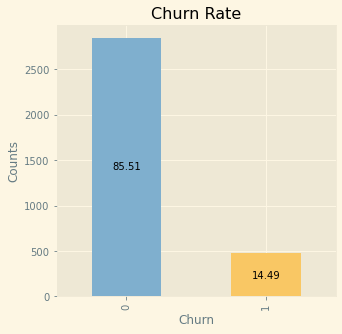

In [54]:
# Checking churn data distribution
nc_percent = round(df_region.churn.value_counts(normalize=True)[0]*100,2)
c_percent = round(df_region.churn.value_counts(normalize=True)[1]*100,2)

with plt.style.context('Solarize_Light2'):
    plt.figure(figsize=(5,5))
    df_region['churn'].value_counts().plot(kind='bar', color=['#7FAFCE',
                                                              '#F9C764'])
    plt.text(-0.1, 1400, f'{nc_percent}')
    plt.text(.90, 200, f'{c_percent}')
    plt.xlabel('Churn')
    plt.ylabel('Counts')
    plt.title('Churn Rate')
    plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>14.49% of the customers in the dataset canceled their services.</li>
        <li>The dataset is clearly unbalanced. Resampling techniques will be required.</li>
    </ul>
</div>

### Check Columns Features Correlation with Churn

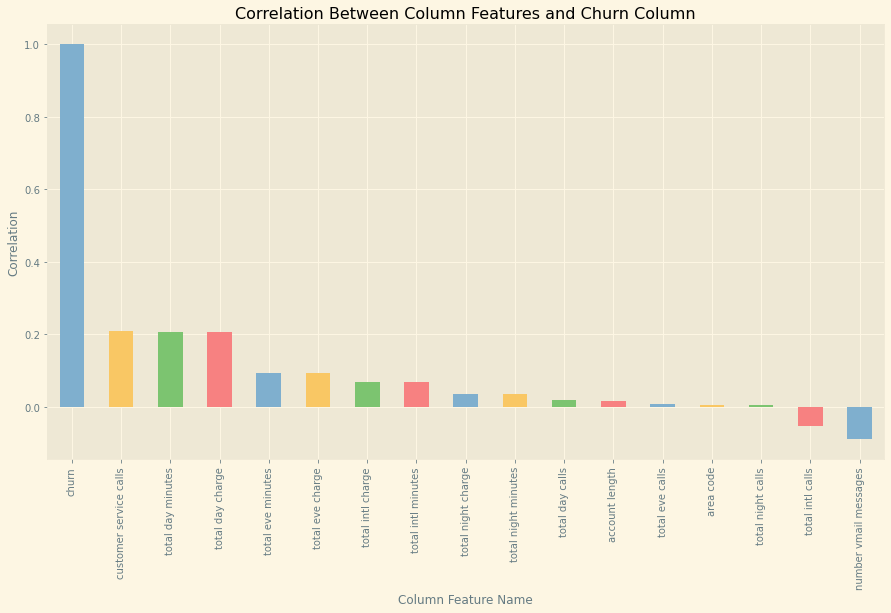

In [55]:
#Get Correlation of "Churn" with other variables:
with plt.style.context('Solarize_Light2'):
    plt.figure(figsize=(15,8))
    df_region.corr()['churn'].sort_values(ascending = False)\
                             .plot(kind='bar',
                             color=['#7FAFCE','#F9C764','#7CC470', '#F78181'])
    plt.xlabel('Column Feature Name')
    plt.ylabel('Correlation')
    plt.title('Correlation Between Column Features and Churn Column')
    plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>None of the column feature shows a strong correlation with the churn feature.</li>
        <li>Two columns display an inverse correlation with the churn column, namely 'total intl calls' and 'number vmail messages'.</li>
    </ul>
</div>

### Check Multicollinearity Among Independent Features

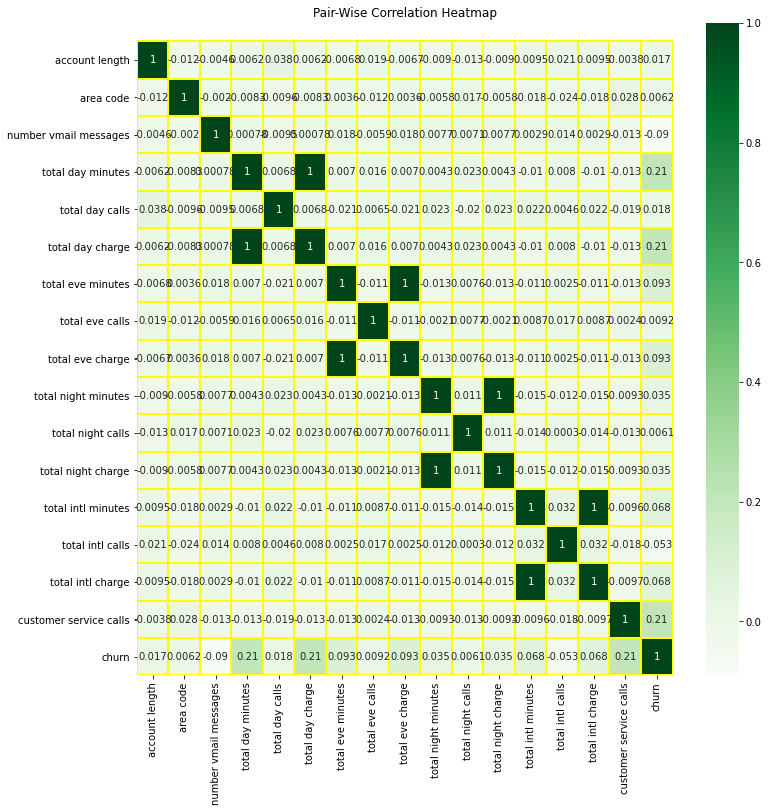

In [56]:
# A graphical representation of the pair-wise correlation using heatmap
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df_region.iloc[:,].corr(), cmap='Greens', annot=True, linewidths=1, linecolor='yellow')
ax.set_ylim(len(df_region.iloc[:,:].corr())-0, -0.5)
ax.set_title("Pair-Wise Correlation Heatmap")
plt.show()


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>There are a few independent features showing high correlation with one another.</li>
        <li>We will need to drop 'total day charge', 'total eve charge', 'total night charge' and 'total intl charge' so we don't violate the multicollinearity assumption for Logistic Regression.</li>
        <li>After dropping the 4 columns, we still have 11 features available to meet the project requirements.
    </ul>
</div>

### Check Column Features by Churn

In [57]:
# Separate categorical and numerical columns
# Get categorical and numerical column names
cat_fea = df_region.select_dtypes(object).columns
int_fea = df_region.select_dtypes('int64').columns
flt_fea = df_region.select_dtypes('float64').columns

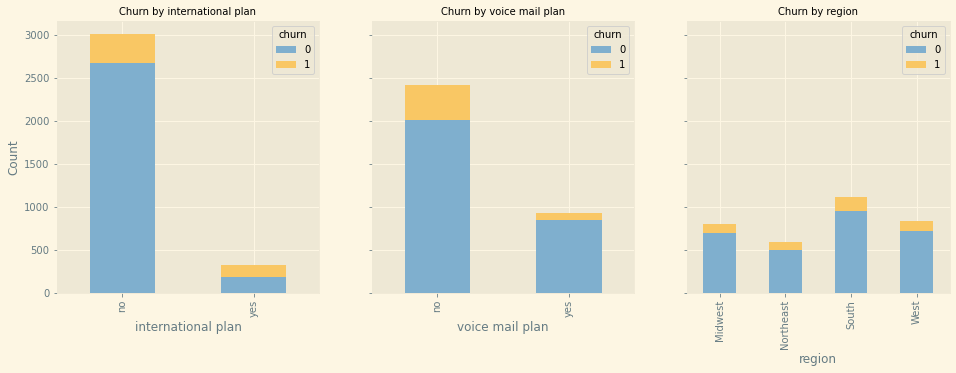

In [58]:
# Plot the churn rate by categorical features
with plt.style.context('Solarize_Light2'):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5), sharey=True)
    for xcol, ax in zip(cat_fea, axes):
        df_region.groupby([xcol, 'churn']).size()\
                                          .unstack()\
                                          .plot(kind='bar',
                                                stacked=True, ax=ax,
                                                color=['#7FAFCE','#F9C764'])
        ax.set_ylabel('Count')
        ax.set_title(f'Churn by {xcol}', size=10)
    plt.show()

In [59]:
# Calculate 'churn' rates in each respective regions
print('\n***** Churn by Region *****\n')
(round(df_region.groupby('region')['churn'].value_counts(normalize=True)* 100, 2)
.astype(str) + '%')


***** Churn by Region *****



region     churn
Midwest    0        87.03%
           1        12.97%
Northeast  0        83.08%
           1        16.92%
South      0        85.21%
           1        14.79%
West       0        86.16%
           1        13.84%
Name: churn, dtype: object

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>True churn rates are higher for customers with an international plan.  Almost half of the international plan subscribers cancel their services while only a small portion of the customers without a international plan cancel their accounts.</li>
        <li>Customers without the voice mail plan have substantial more true churn rates.</li>
        <li>True churn rate with respect to each region are about on the same level.  Northeast is approximately 4% higher than the region with the lowest true churn rates.</li>
    </ul>
</div>

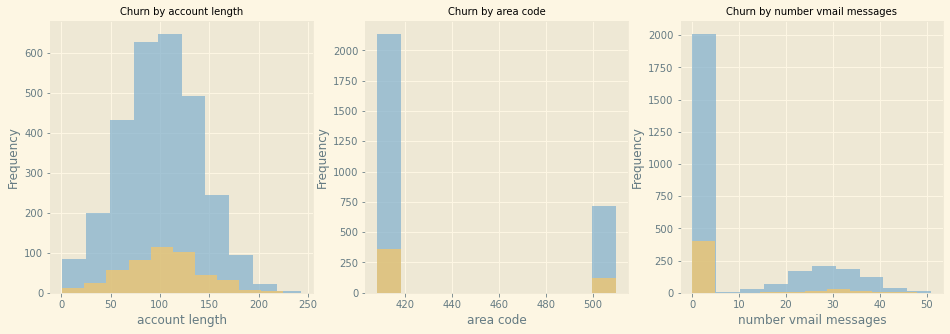

In [60]:
# Plot churn rate by numerical features
fea_churn_plot(df_region, int_fea, (0,3))

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>True churn rate is at the highest when customers have the services for 3 months or so. We wonder this could be due to some type of promotional periods expiring and people are canceling their services.</li>
        <li>There are only 3 area codes for 51 states, which doesn't add up.  We will drop the column. </li>
        <li>Customers with very few voice mail messages tend to have a higher true churn rate.</li>
    </ul>
</div>

In [61]:
# Drop the area code column
df_region.drop(columns='area code', axis=1, inplace=True)

# Verify drop
(df_region.columns == 'area code').sum()

0

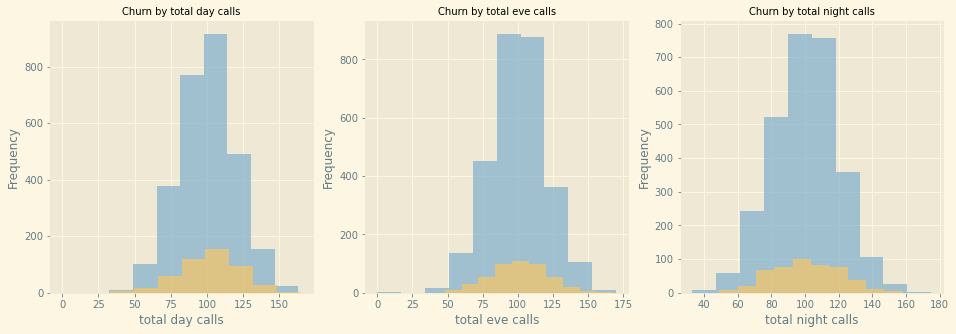

In [62]:
# Plot churn rate by numerical features
fea_churn_plot(df_region, int_fea, (3,6))

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Across all three plots, highest true churn rate can be found associated with customers making about 100 calls throughout day, eve and night call categories.</li>
    </ul>
</div>

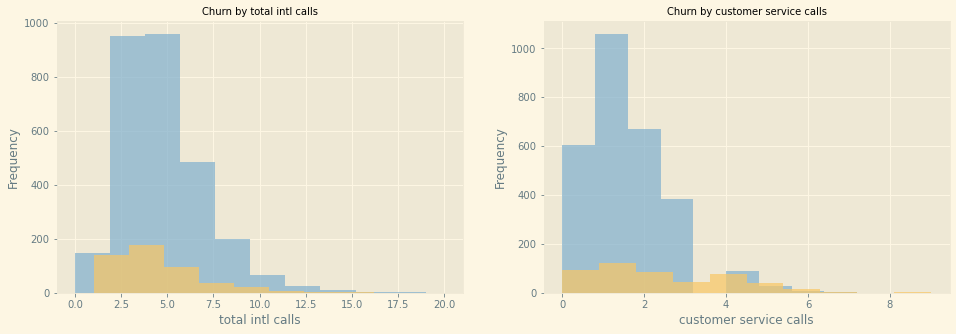

In [63]:
# Plot churn rate by numerical features
fea_churn_plot(df_region, int_fea, (6,8))

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The true churn rate by total international calls seems to be proportionally related to false churn rates.  Both display similar data distribution.</li>
        <li>When the 'customer service calls' feature has a value more than 3.5, we don't see lot of false churn rate but rather high churn rate.  This could indicate that the more the customers contact the service department, the more likely they would churn.</li>
    </ul>
</div>

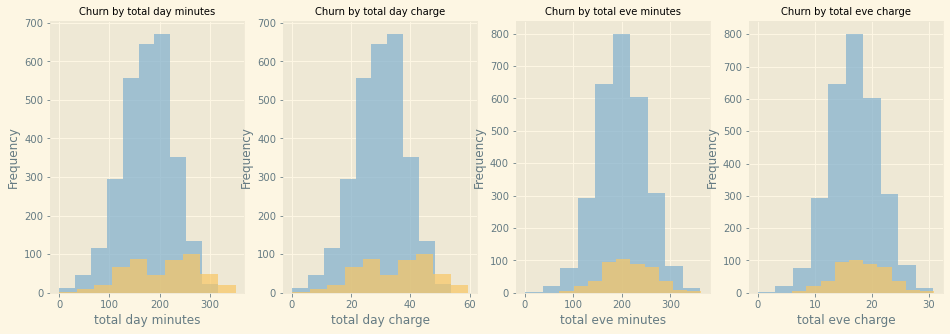

In [64]:
# Plot churn rate by numerical features
fea_churn_plot(df_region, flt_fea, (0,4))

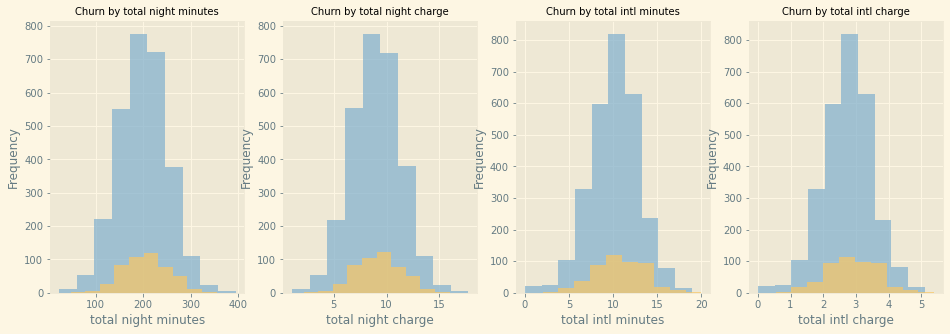

In [65]:
# Plot churn rate by numerical features
fea_churn_plot(df_region, flt_fea, (4,8))

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Features data seem to be normally distributed.</li>
        <li>Most true churn rates occur around the mean of the features.</li>
        <li>Total day minutes and total day charge upper bins do not contain any false churn rates.  We have 100% true churn rates in the upper bins.</li>
    </ul>
</div>

In [66]:
# Drop 'total day charge', 'total eve charge', 'total night charge'
# and 'total intl charge' due to perfect correlation
col_to_drop = ['total day charge', 'total eve charge',
               'total night charge', 'total intl charge'] 

df_region.drop(columns=col_to_drop, axis=1, inplace=True)

# Verify drop
len([col for col in df_region.columns if 'charge' in col])

0

***
## Premodeling Preparations

In [67]:
# Separate labels and features
y = df_region.churn.copy()
X = df_region.drop(columns='churn', axis=1).copy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=36 )
print(X_train.shape, X_test.shape)

(2499, 14) (834, 14)


### One Hot Encoding

The reason we are not including the encoding in the pipeline is due to subsequent steps involving grid search.

In [68]:
# One hot encoding training data
X_train_ohe = pd_ohe(X_train)

# Preview data
X_train_ohe.head()

,international plan_yes,voice mail plan_yes,region_Northeast,region_South,region_West,account length,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls
996,0,0,0,0,1,31,0,177.3,129,152.8,105,162.9,92,5.1,2,0
1396,0,1,0,0,1,118,36,294.9,106,165.7,115,189.2,63,9.8,5,3
2421,1,0,0,0,1,124,0,244.6,89,188.8,80,206.0,114,11.3,4,1
642,0,0,0,0,0,65,0,129.1,137,228.5,83,208.8,111,12.7,6,4
2191,0,0,0,0,1,97,0,146.0,121,203.0,141,151.8,120,13.3,2,1


In [69]:
# One hot encoding test data
X_test_ohe = pd_ohe(X_test)

# Preview data
X_test_ohe.head()

,international plan_yes,voice mail plan_yes,region_Northeast,region_South,region_West,account length,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls
1038,0,1,0,0,1,47,28,172.9,109,137.6,94,203.8,109,8.3,6,1
3241,0,1,1,0,0,146,23,149.6,96,239.8,124,293.5,135,7.4,4,2
1523,0,1,0,0,0,131,36,214.2,115,161.7,117,264.7,102,9.5,4,3
532,0,0,0,1,0,62,0,186.8,94,207.6,92,195.0,98,8.8,4,3
1013,0,0,0,0,1,60,0,221.1,106,178.6,48,202.7,90,7.4,3,1


***
## Baseline Model

In [1]:
t = ['a', 'b', 'c', 'd']

In [3]:
a, b, c, d = [x for x in t]

In [4]:
a,b,c,d

('a', 'b', 'c', 'd')